In [1]:
import torch
import numpy as np
import pandas as pd
from lib.data_utils import *
from lib.model_utils import *
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.nn.functional import one_hot

# Load data & models

## Data

In [2]:
df_train, df_train_y, df_optimization, df_optimization_y, df_test, df_test_y, complete_feature_set, features_model = load_model_training_data_template(train_sets = ['data/wyscout/csv/events/Italy.csv', 'data/wyscout/csv/events/Germany.csv', 'data/wyscout/csv/events/France.csv'], optimization_sets = ['data/wyscout/csv/events/hack_train.csv',], test_sets = ['data/wyscout/csv/events/Spain.csv', 'data/wyscout/csv/events/England.csv'])

In [3]:
print(complete_feature_set)

['subtype_id_1', 'subtype_id_2', 'subtype_id_3', 'subtype_id_4', 'subtype_id_5', 'subtype_id_6', 'subtype_id_7', 'subtype_id_8', 'subtype_id_9', 'subtype_id_10', 'subtype_id_11', 'subtype_id_12', 'subtype_id_13', 'subtype_id_14', 'subtype_id_15', 'subtype_id_16', 'subtype_id_17', 'subtype_id_18', 'subtype_id_19', 'subtype_id_20', 'subtype_id_21', 'subtype_id_22', 'subtype_id_23', 'subtype_id_24', 'subtype_id_25', 'subtype_id_26', 'subtype_id_27', 'subtype_id_28', 'subtype_id_29', 'subtype_id_30', 'subtype_id_31', 'subtype_id_32', 'subtype_id_33', 'period', 'minute', 'x', 'y', 'is_home_team', 'accurate', 'goal', 'home_score', 'away_score', 'next_action_x', 'next_action_y', 'next_action_type_1', 'next_action_type_2', 'next_action_type_3', 'next_action_type_4', 'next_action_type_5', 'next_action_type_6', 'next_action_type_7', 'next_action_type_8', 'next_action_type_9', 'next_action_type_10', 'next_action_type_11', 'next_action_type_12', 'next_action_type_13', 'next_action_type_14', 'next_

# Simulation class

In [4]:
from lib.simulator import *

In [5]:
sim = Simulator(
    model_type_path='models/lem/LEMv3_MODEL_TYPE_TORCH.pth',
    model_acc_path='models/lem/LEMv4_MODEL_ACC_TORCH.pth',
    model_data_path='models/lem/LEMv3_MODEL_DATA_TORCH.pth')

c:\Users\jjate\OneDrive\Desktop\LargeEventsModel\lib\simulator.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model_type = torch.load(model_type_path).to(self.dev

In [6]:
feature_tensor, all_sims_data = sim.simulate([1 if i == 27 else 0 for i in range(33)] + [0, 0, 0.5, 0.5, 1, 1, 0, 0, 0], store_full_sim=True, n_sims=10000)

 91%|█████████ | 1822/2000 [00:51<00:04, 35.65it/s]


# Post-simulation analysis

In [7]:
data = pd.DataFrame(feature_tensor)
data['type_id'] = data[data.columns[:33]].idxmax(axis=1) + 1
data = data.drop(data.columns[:33], axis=1)
data.columns = ['period', 'minute', 'x', 'y', 'is_home_team', 'accurate', 'goal', 'home_score', 'away_score', 'type_id']
data.home_score = (data.home_score * 10).astype(int)
data.away_score = (data.away_score * 10).astype(int)
data

,period,minute,x,y,is_home_team,accurate,goal,home_score,away_score,type_id
0,2.0,0.256667,0.59,0.57,0.0,0.0,0.0,1,0,28
1,2.0,0.049722,0.79,0.24,1.0,0.0,0.0,1,1,23
2,2.0,0.175833,0.72,0.81,0.0,1.0,0.0,0,1,1
3,2.0,0.403333,0.93,0.31,1.0,0.0,0.0,2,2,1
4,2.0,0.146944,0.76,0.41,0.0,0.0,0.0,1,1,2
...,...,...,...,...,...,...,...,...,...,...
9995,2.0,0.210278,0.00,1.00,1.0,1.0,0.0,0,2,31
9996,2.0,0.189167,0.35,0.33,1.0,1.0,0.0,0,1,1
9997,2.0,0.308333,0.22,0.76,1.0,1.0,0.0,1,2,4
9998,2.0,0.157778,0.68,0.74,1.0,1.0,0.0,4,0,28


In [8]:
data.period.value_counts()

period
2.0    10000
Name: count, dtype: int64

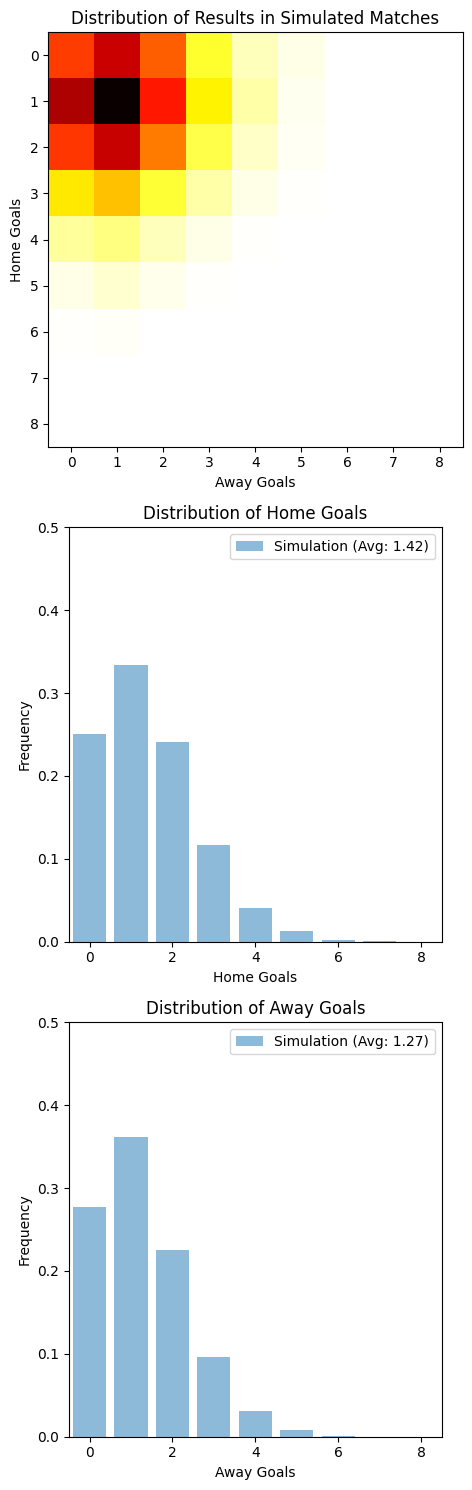

In [22]:
plt.rcParams['figure.figsize'] = (9, 15)  # Adjusted height for 3 plots

# Simulated data setup for the pivot_table and bar plots

# First plot: Distribution of Results in Simulated Matches
plt.subplot(3, 1, 1)  # First of 3 rows
plt.title('Distribution of Results in Simulated Matches')
plt.imshow(data.pivot_table(index='home_score', columns='away_score', values='x', aggfunc='count'), cmap='hot_r')
plt.ylim(8.5, -0.5)
plt.xlim(-0.5, 8.5)
plt.ylabel('Home Goals')
plt.xlabel('Away Goals')
plt.gca().set_aspect('equal', adjustable='box')

# Second plot: Distribution of Home Goals
df_results = pd.DataFrame(feature_tensor[:, 40:42] * 10, columns=['HG', 'AG'])
plt.subplot(3, 1, 2)  # Second of 3 rows
plt.bar(df_results.groupby('HG').HG.count().index, 
        df_results.groupby('HG').HG.count() / df_results.groupby('HG').HG.count().sum(), 
        alpha=0.5, label=f'Simulation (Avg: {df_results["HG"].mean():.2f})')
plt.legend()
plt.title('Distribution of Home Goals')
plt.xlabel('Home Goals')
plt.ylabel('Frequency')
plt.xlim(-0.5, 8.5)
plt.ylim(0, 0.5)
plt.gca().set_aspect(20, adjustable='box')

# Third plot: Distribution of Away Goals
plt.subplot(3, 1, 3)  # Third of 3 rows
plt.bar(df_results.groupby('AG').AG.count().index, 
        df_results.groupby('AG').AG.count() / df_results.groupby('AG').AG.count().sum(), 
        alpha=0.5, label=f'Simulation (Avg: {df_results["AG"].mean():.2f})')
plt.legend()
plt.xlim(-0.5, 8.5)
plt.ylim(0, 0.5)
plt.title('Distribution of Away Goals')
plt.xlabel('Away Goals')
plt.ylabel('Frequency')
plt.gca().set_aspect(20, adjustable='box')

# Adjust layout
plt.tight_layout()
plt.show()

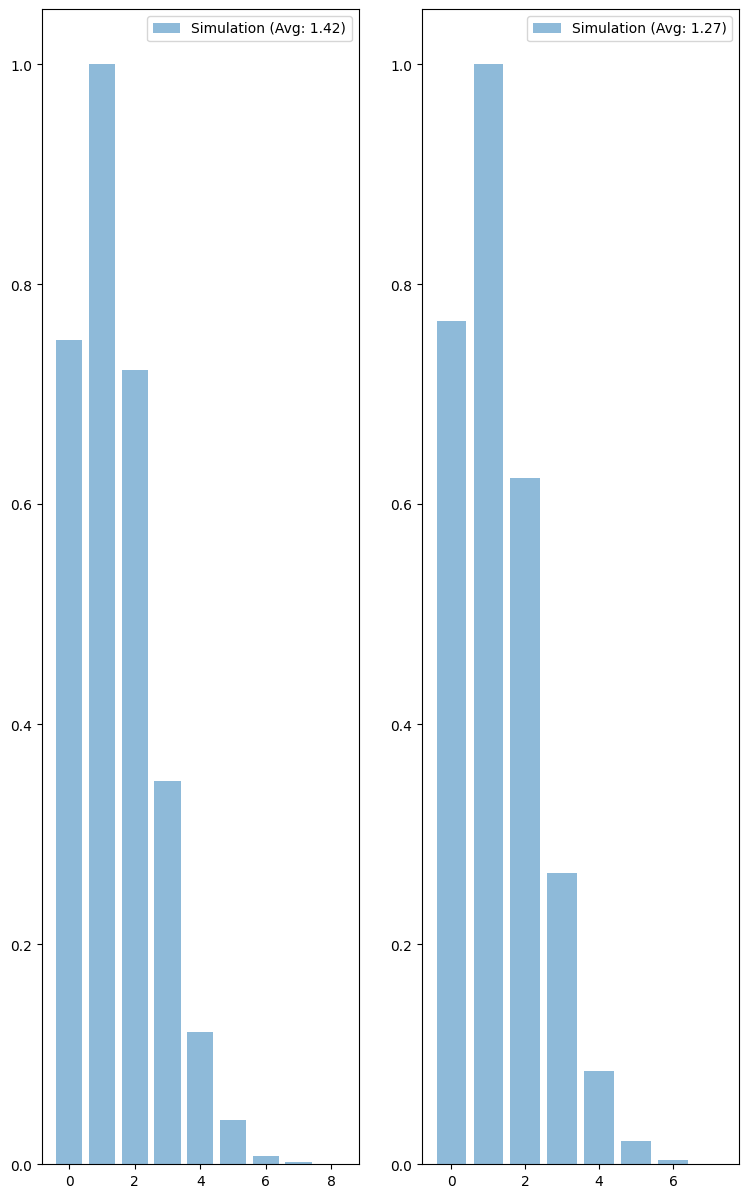

In [24]:
df_results = pd.DataFrame(feature_tensor[:, 40:42] * 10, columns=['HG', 'AG'])
plt.subplot(121)
plt.bar(df_results.groupby('HG').HG.count().index, df_results.groupby('HG').HG.count()/df_results.groupby('HG').HG.count().max(), alpha=0.5, label=f'Simulation (Avg: {df_results["HG"].mean():.2f})')
plt.legend();
plt.subplot(122)
plt.bar(df_results.groupby('AG').AG.count().index, df_results.groupby('AG').AG.count()/df_results.groupby('AG').AG.count().max(), alpha=0.5, label=f'Simulation (Avg: {df_results["AG"].mean():.2f})')
plt.legend();

# plt.savefig('figures/paper_lem/distribution_scores.pdf', bbox_inches='tight')

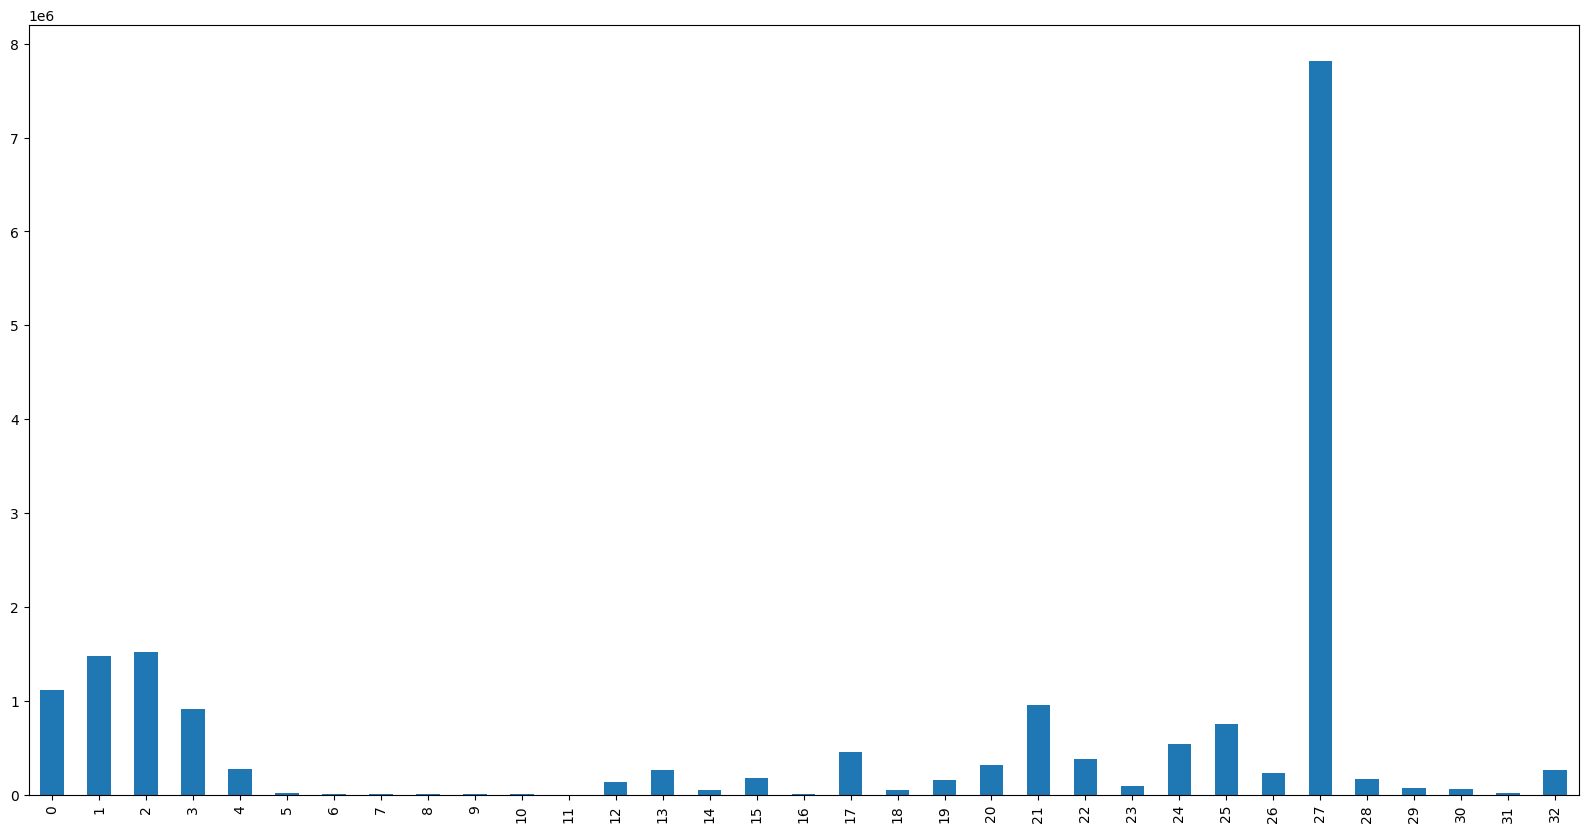

In [25]:
data = pd.DataFrame(torch.concat(all_sims_data))
data[data.columns[0:33]].sum().plot.bar(figsize=(20, 10));

In [26]:
df_all_data = []
for i in range(len(all_sims_data)):
    data = pd.DataFrame(all_sims_data[i])
    data['type_id'] = data[data.columns[:33]].idxmax(axis=1) + 1
    data = data.drop(data.columns[:33], axis=1)
    data.columns = ['period', 'minute', 'x', 'y', 'is_home_team', 'accurate', 'goal', 'home_score', 'away_score', 'type_id']
    data['event_id'] = i
    data['game_id'] = [i for i in range(len(all_sims_data[i]))]
    df_all_data.append(data)

In [27]:
df_all_data = pd.concat(df_all_data)
df_all_data.minute *= 60
df_all_data.x *= 100
df_all_data.y *= 100
df_all_data.home_score = (df_all_data.home_score * 10).astype(int)
df_all_data.away_score = (df_all_data.away_score * 10).astype(int)
df_all_data['type_name'] = df_all_data.type_id.map({v: k for k, v in SUBEVENT_TYPE_MAP.items()})
df_all_data = df_all_data.reset_index(drop=True)

In [28]:
df_all_data.sample(10)

,period,minute,x,y,is_home_team,accurate,goal,home_score,away_score,type_id,event_id,game_id,type_name
12882614,1.0,36.999962,75.000000,7.000000,1.0,1.0,0.0,1,1,28,1288,2614,simple_pass
15462159,1.0,43.816635,88.000000,66.000000,1.0,0.0,0.0,1,0,23,1546,2159,cross
8391026,1.0,6.000001,89.000000,56.000000,0.0,1.0,0.0,1,1,33,839,1026,shot
8301108,0.0,42.883293,13.000000,58.999996,1.0,0.0,0.0,2,0,22,830,1108,touch
12423044,1.0,29.383339,76.000000,9.000000,0.0,0.0,0.0,0,3,23,1242,3044,cross
2193160,0.0,10.183331,46.000000,25.000000,0.0,1.0,0.0,0,1,28,219,3160,simple_pass
20241,0.0,0.100000,81.000000,88.000000,1.0,1.0,0.0,0,0,2,2,241,ground_attacking_duel
16816457,2.0,3.816667,60.000004,29.000000,0.0,1.0,0.0,3,0,28,1681,6457,simple_pass
1252376,0.0,6.950000,40.000000,92.000000,1.0,1.0,0.0,0,0,28,125,2376,simple_pass
1740923,0.0,10.483331,32.000000,9.000000,0.0,1.0,0.0,0,0,28,174,923,simple_pass


In [29]:
df_all_data[df_all_data.period <= 1].groupby('game_id').minute.count().mean(), df_train.groupby('match_id').minute.count().mean()

(1574.553, 1612.232645403377)

In [30]:
diffs = []
for game_id in df_all_data.game_id.unique():
    diffs.append(df_all_data[df_all_data.game_id == game_id].minute.diff().dropna().values)
diffs = np.concatenate(diffs)
diffs = diffs[diffs > -10]
plt.hist(diffs, bins=100);

In [ ]:
len(df_all_data), df_all_data.goal.sum(), df_all_data[df_all_data.type_name.isin(['shot', 'penalty', 'free_kick_shot'])].goal.sum(), data.home_score.sum()*10, data.away_score.sum()*10

(1832000, 6125.0, 3091.0, 1359.0000915527344, 1286.0000610351562)

In [ ]:
[
    len(df_all_data[df_all_data.type_name == 'shot']), 
    df_all_data.goal.sum(), 
    df_all_data[df_all_data.type_name == 'shot'].goal.sum(), 
    df_all_data[df_all_data.type_name == 'penalty'].goal.sum(), 
    df_all_data[df_all_data.type_name == 'direct_free_kick'].goal.sum(), 
    len(df_all_data[df_all_data.type_name == 'shot']) / len(df_all_data), 
    df_all_data[df_all_data.type_name == 'shot'].goal.sum()/len(df_all_data[df_all_data.type_name == 'shot']),
]

[26782, 6125.0, 2821.0, 206.0, 0.0, 0.014618995633187772, 0.10533193936225824]

In [ ]:
pd.DataFrame([{
    'goal': round(df_all_data['goal'].sum() / len(df_all_data) * 100,3),
    'goal/shot': round(df_all_data[df_all_data.type_name == 'shot'].goal.sum() / len(df_all_data[df_all_data.type_name == 'shot']) * 100,3),
    'shot': round(len(df_all_data[df_all_data.type_name == 'shot']) / len(df_all_data) * 100,2), 
    'simple_pass': round(len(df_all_data[df_all_data.type_name == 'simple_pass']) / len(df_all_data) * 100,1), 
    'ground_attacking_duel': round(len(df_all_data[df_all_data.type_name == 'ground_attacking_duel']) / len(df_all_data) * 100,1), 
    'ground_defending_duel': round(len(df_all_data[df_all_data.type_name == 'ground_defending_duel']) / len(df_all_data) * 100,1), 
    'touch': round(len(df_all_data[df_all_data.type_name == 'touch']) / len(df_all_data) * 100,1), 
    'air_duel': round(len(df_all_data[df_all_data.type_name == 'air_duel']) / len(df_all_data) * 100,1), 
    'high_pass': round(len(df_all_data[df_all_data.type_name == 'high_pass']) / len(df_all_data) * 100,1), 
    'throw_in': round(len(df_all_data[df_all_data.type_name == 'throw_in']) / len(df_all_data) * 100,1), 
    'cross': round(len(df_all_data[df_all_data.type_name == 'cross']) / len(df_all_data) * 100,1), 
    'free_kick': round(len(df_all_data[df_all_data.type_name == 'free_kick']) / len(df_all_data) * 100,1), 
    'foul': round(len(df_all_data[df_all_data.type_name == 'foul']) / len(df_all_data) * 100,1), 
},
{
    'goal': round(df_train['goal'].sum() / len(df_train) * 100,3),
    'goal/shot': round(df_train[df_train.subtype_name == 'shot'].goal.sum() / len(df_train[df_train.subtype_name == 'shot']) * 100,3),
    'shot': round(len(df_train[df_train.subtype_name == 'shot']) / len(df_train) * 100,2), 
    'simple_pass': round(len(df_train[df_train.subtype_name == 'simple_pass']) / len(df_train) * 100,1), 
    'ground_attacking_duel': round(len(df_train[df_train.subtype_name == 'ground_attacking_duel']) / len(df_train) * 100,1), 
    'ground_defending_duel': round(len(df_train[df_train.subtype_name == 'ground_defending_duel']) / len(df_train) * 100,1), 
    'touch': round(len(df_train[df_train.subtype_name == 'touch']) / len(df_train) * 100,1), 
    'air_duel': round(len(df_train[df_train.subtype_name == 'air_duel']) / len(df_train) * 100,1), 
    'high_pass': round(len(df_train[df_train.subtype_name == 'high_pass']) / len(df_train) * 100,1), 
    'throw_in': round(len(df_train[df_train.subtype_name == 'throw_in']) / len(df_train) * 100,1), 
    'cross': round(len(df_train[df_train.subtype_name == 'cross']) / len(df_train) * 100,1), 
    'free_kick': round(len(df_train[df_train.subtype_name == 'free_kick']) / len(df_train) * 100,1), 
    'foul': round(len(df_train[df_train.subtype_name == 'foul']) / len(df_train) * 100,1), 
}])

,goal,goal/shot,shot,simple_pass,ground_attacking_duel,ground_defending_duel,touch,air_duel,high_pass,throw_in,cross,free_kick,foul
0,0.334,10.533,1.46,42.8,8.1,8.3,5.2,6.2,4.1,2.5,2.1,1.4,1.4
1,0.333,10.291,1.40,41.4,9.1,9.0,5.7,5.2,4.2,2.8,2.0,1.5,1.6


In [ ]:
df_all_data[['goal', 'type_name']].value_counts()

goal  type_name              
0.0   simple_pass                784870
      ground_defending_duel      152692
      ground_attacking_duel      148491
      air_duel                   112901
      touch                       95073
      ground_loose_ball_duel      90964
      high_pass                   75596
      head_pass                   54464
      throw_in                    45610
      cross                       38416
      clearance                   31803
      foul                        26541
      free_kick                   25933
      shot                        23961
      launch                      23424
      goal_kick                   18197
      smart_pass                  16384
      acceleration                15629
      corner                      13428
      hand_pass                    9688
      free_kick_cross              5145
      save_attempt                 4925
      reflexes                     4550
      goalkeeper_leaving_line      4286
1.0   shot